# 차원 축소

많은 경우 머신러닝 문제는 훈련샘플이 각각이 수천 심지어 수백만 개의 특성을 가지고 있음.

이런 많은 특성은 훈련을 느리게 할 뿐만 아니라, 앞으로 보게 되겠지만 좋은 솔루션을 찾기 어렵게 만듦.

이런 문제를 종종 차원의 저주라고 함.

|

다행히도 실전 문제에서는 특성 수를 크게 줄여서 불가능한 문제를 가능한 범위로 변경할 수 있는 경우가 많음.

#### CAUTION_ 

차원을 축소시키면 일부 정보가 유실됨(JPEG로 이미지를 압축하면 품질이 감소되는 것처럼).

그래서 훈련속도가 빨라질 수는 있으나 시스템의 성능이 조금 나빠질 수 있음.

또한 작업 파이프라인이 좀 더 복잡하게 되고 유지 관리가 어려워짐. 그러므로 차원축소를 고려하기 전에

훈련이 너무 느린지 먼저 원본 데이터로 시스템을 훈련해봐야 함.

어떤 경우에는 훈련 데이터의 차원을 축소시키면 잡음이나 불필요한 세부사항을 걸러내므로 성능을 높일 수 있음.

일반적으로는 훈련 속도만 빨라짐.

훈련속도를 높이는 것 외에 차원축소는 데이터 시각화(or DataViz)에도 아주 유용함.

차원 수를 둘로(또는 셋으로) 줄이면 고차원 훈련세트를 하나의 압축된 그래프로 그릴 수 있고

군집과 같은 시각적인 패턴을 감지해 중요한 통찰을 얻는 경우가 많습니다.

또한 데이터 과학자가 아닌 사람들, 특히 최종결과를 사용하는 결정권자에게 여러분의 판단을

설명하는데 데이터 시각화는 필수.

이번 장에서는 차원의 저주에 대해 논의하고 고차원공간에서 어떤 일이 일어나는지 알아보겠다.

그런 다음 차원 축소에 사용되는 2가지 주요접근법(투영과 매니폴드)를 소개하겠다.

마지막으로 가장 인기있는 차원축소 기법인 PCA, 커널 PCA, LLE를 다루도록 하겠다.

## 차원의 저주

우리는 3차원 세계에서 살고 있어서 고차원공간을 직관적으로 상상하기 어려움.

1000차원의 공간에서 휘어져있는 200차원의 타원체는 고사하고 기본적인 4차원 초입방체 조차 매우 어려움.

고차원 공간에선느 많은 것이 상당히 다르게 작동함.

예를 들어 단위면적(1 * 1 사각형) 안에 있는 점을 무작위로 선택한다면 

경계선에서 0.001이내에 위치할 가능성은 0.4%

(어느방향으로든 거의 끝부분에 있는 점을 선택할 가능성은 매우 낮다는 뜻).

하지만 10,000차원의 단위 면적을 가진 초입방체에서는 이 가능성이 99.999999%보다 커짐

고차원 초입방체에 있는 대다수의 점은 경계와 매우 가깝게 있음.

여기에 더 심각한 차이점이 존재. 단위 면적에서 임의의 두 점을 선택하면 

두 점 사이의 거리는 평균적으로 약 0.52가 됨. 3차원 큐브에서 임의의 두 점을 선택하면 평균거리는

약 0.66임. 만약 1,000,000차원 초입방체에서 두 점을 무작위로 선택하면 어떨까?

믿거나 말거나 평균거리는 약 408.25(약 $\sqrt{1,000,000/6}$)!

이는 직관적이지 않음. 두 점이 단위초입방체에 같이 놓여 있는데 어떻게 이렇게 멀리 떨어져 있나?

|

고차원은 많은 공간을 가지고 있기 떄문. 이로 인해 고차원 데이터셋은 매우 희박할 위험이 있음.

즉, 대부분의 훈련데이터가 서로 멀리 떨어져 있음. => 새로운샘플도 훈련샘플과 멀리 떨어져 있을 가능성 높음.

이 경우 예측을 위해 훨씬 많은 외삽(extrapolation)을 해야하기에 저차원일 때보다 예측이 불안정

=> 훈련세트의 차원이 클수록 과대적합 위험 상승.

이론적으로 차원의 저주를 해결하는 방법 중 하나는 훈련샘플의 밀도가 충분히 높아질 때까지

훈련세트의 크기를 키우는 것. 불행히도 실제로는 일정 밀도에 도달하기 위해 필요한 훈련샘플 수는

차원 수가 커짐에 따라 기하급수적으로 늘어남. 

특성 수가 단 100개라 해도, 모든 차원에 걸쳐 균일하게 퍼져 있다고 가정하고 훈련샘플을 서로

평균 0.1 이내에 위치시키려면 관측가능한 우주에 있는 원자 수 모두를 합친 것보다 더 많은 훈련샘플이 필요.

In [1]:
import numpy as np
import os

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 차원축소를 위한 접근 방법

### 투영

대부분의 실전문제는 훈련샘플이 모든 차원에 걸쳐 균일하게 퍼져 있지 않음.

많은 특성은 변화가 없는 반면, 다른 특성들은 서로 강하게 연관되어 있음.

결과적으로 모든 훈련 샘플이 고차원 공간 안의 저차원 부분공간에 놓여있음.

너무 추상적이라 그림으로 설명이 필요.

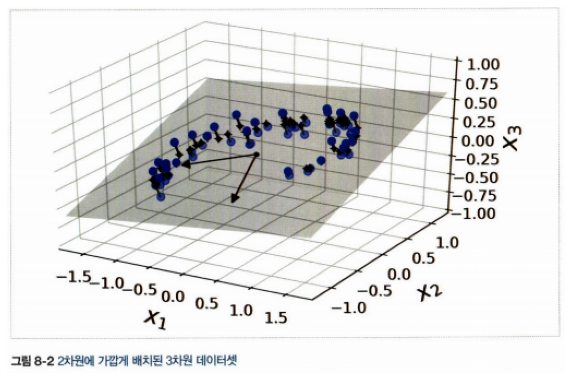

In [2]:
import matplotlib.image as mpimg

filename = "dim_red2.png"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
show_img = mpimg.imread(os.path.join(images_path, filename))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(show_img)

[8-2]에 원모양을 띤 3차원 데이터셋이 있음. 모든 훈련샘플이 거의 평면형태로 놓여있음.

이것이 고차원(3D) 공간에 있는 저차원 (2D) 부분 공간임. 여기서 모든 훈련샘플을 이 부분공간에 수직으로

투영하면 [8-3]과 같은 2D 데이터셋 그림을 얻을 수 있음.

각 축은 (평면에 투영된 좌표인) 새로운 특성 $z_1$ 과 $z_2$ 에 대응됨.

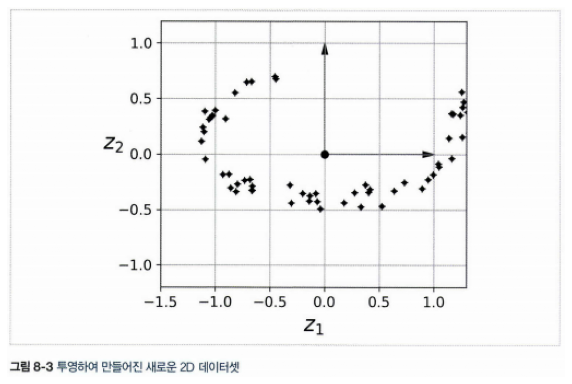

In [3]:
filename = "dim_red3.png"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
show_img = mpimg.imread(os.path.join(images_path, filename))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(show_img)

그러나 차원축소에 있어서 투영이 언제나 최선은 아님. 많은 경우 [8-4]처럼 표현된 

스위스롤 데이터셋처럼 부분 공간이 뒤틀리거나 휘어 있기도 함.

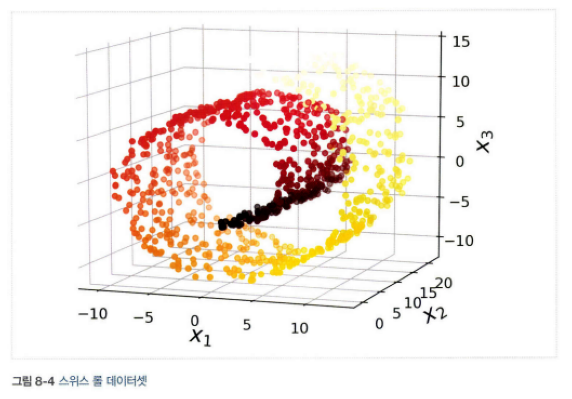

In [4]:
filename = "dim_red4.png"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
show_img = mpimg.imread(os.path.join(images_path, filename))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(show_img)

그냥 평면에 투영시키면 [8-5]처럼 스위스 롤의 층이 서로 뭉개짐. 우리가 원하는 것은

스위스 롤은 펼쳐서 오른쪽처럼 2D 데이터셋을 얻는 것

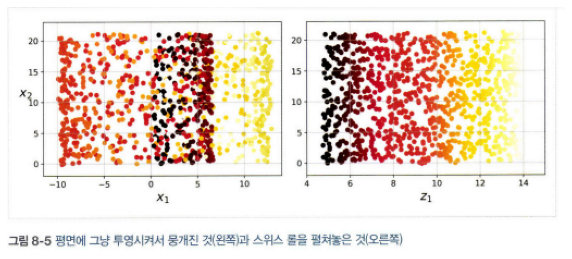

In [5]:
filename = "dim_red5.png"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
show_img = mpimg.imread(os.path.join(images_path, filename))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(show_img)

### 매니폴드 학습

스위스롤은 매니폴드의 한 예시로 간단히 말해 2D 매니폴드는 고차원 공간에서 휘어지거나 뒤틀린 2D 모양임.

더 일반적으로 $d$ 차원 매니폴드는 국부적으로 $d$ 차원 초평면으로 보일 수 있는 $n$ 차원 공간의 일부.

($ d < n $)

|

많은 차원 축소 알고리즘이 훈련샘플이 놓여잇는 매니폴드를 모델링하는 식으로 작동. => 매니폴드 학습

이는 대부분 실제 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가깝게 놓여 있다는 매니폴드 가정(가설)에 근거

경험적으로 이런 가정은 매우 자주 발견됨.

여기서도 MNIST 데이터셋으로 생각해보겠습니다.

전체 손글씨 숫자 이미지는 어느 정도 비슷한 면이 존재. 선으로 연결되어 있고 

어떤 경계는 흰색이고 어느 정도 중앙에 위치. 

무작위로 생성된 이미지라면 그중 아주 적은 일부만 손글씨 숫자처럼 보일 것.

다시 말해 숫자 이미지를 만들 때 가능한 자유도는 아무 이미지나 생성할 때의 자유도보다 훨씬 낮음.

이런 제약이 데이터셋을 압축할 수 있도록 함.

매니폴드 가정은 처리해야 할 작업이 저차원의 매니폴드 공간에 표현되면 더 간단해질 것이라는 가정과 병행. 

이 가정이 항상 유효하지는 않음.

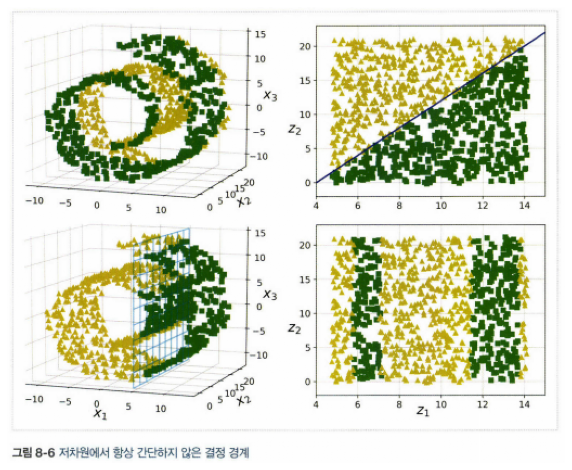

In [6]:
filename = "dim_red6.png"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
show_img = mpimg.imread(os.path.join(images_path, filename))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(show_img)

요약해보자면 모델을 훈련시키기 전에 훈련세트의 차원을 감소시키면 훈련속도는 빨라지나

항상 더 낫거나 간단한 솔루션이 되는 것이 아님. -> 데이터셋마다 다름.

## 주성분 분석(PCA)

데이터에 가장 가까운 초평면을 정의한 다음, 데이터를 초평면에 투영시키는 방법

In [7]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

### 분산 보존

저차원 초평면에 훈련 세트를 투영하기 전에 올바른 초평면을 선택해야 함.

예를 들어 [8-7]의 왼쪽 그래프는 간단한 2D 데이터셋이 3개의 축(즉, 1차원 초평면)과 함께 표현됨.

오른쪽은 데이터셋이 각 축에 투영된 결과. 여기서 볼 수 있듯이 실선에 투영된 것은 분산을 최대로

보존하는 반면, 점선에 투영된 것은 분산을 매우 적게 유지하고 있음.


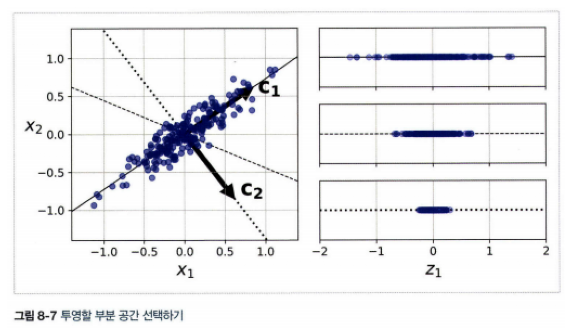

In [8]:
filename = "dim_red7.png"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
show_img = mpimg.imread(os.path.join(images_path, filename))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(show_img)

다른 방향으로 투영하는 것보다 분산이 최대로 보존되는 축을 선택하는 것이 정보가

가장 적게 손실되므로 합리적. 이 선택을 다른방식으로 설명하면 

원본 데이터셋과 투영된 것 사이의 평균 제곱거리를 최소화하는 축.

### 주성분

고차원 데이터셋을 분산이 최대인 축을 계속 찾아가며 축소하는 경우 i번째 

축을 이 데이터의 i번째 주성분(PC)라고 함. [8-7]에서 첫번째 PC는 벡터 $c_1$ 이 놓인 축이고

두번째 PC는 벡터 $c_2$ 가 놓인 축임. [8-2]에서는 처음 2개의 PC는 두 화살표가 놓인 평면의 수직 축.

그리고 세번째 PC는 이 평면에 수직임.

|

#### NOTE_

각 주성분을 위해 PCA는 주성분 방향을 가리키고 원점에 중앙이 맞춰진 단위 벡터를 찾음.

하나의 축에 단위벡터가 반대 방향으로 2개 있으므로 PCA가 반환하는 단위벡터의 방향은

일정하지 않음. 주성분 방향은 일정하지 않음/

훈련세트를 좀 섞은 다음 다시 PCA를 적용하면 새로운 PC중 일부가 원래 PC와 반대방향일 수 있음.

그러나 일반적으로 같은 축에 놓여 있을 것.

어떤 경우에는 한 쌍의 PC가 회전하거나 서로 바뀔 수 있지만 보통은 같은 평면을 구성.

그럼 훈련 세트의 주성분을 어떻게 찾을까? 다행히 특잇값 분해(SVD)라는 표준 행렬 분해 기술이 있어서

훈련세트 행렬 X를 3개 행렬의 행렬 곱셈인 $U\sum\limits V^T$ 로 분해할 수 있음.

|

$X = U \sum V^T$ 에서 $V$가 주성분

* (m, m) (m, n) (n, n)

m: 샘플 개수, n: 특성 개수

**Equation 8-1: Principal components matrix**

$
\mathbf{V}^T =\begin{pmatrix}
  \mid & \mid & & \mid \\
  \mathbf{c_1} & \mathbf{c_2} & \cdots & \mathbf{c_n} \\
  \mid & \mid & & \mid
\end{pmatrix}
$

다음 파이썬 코드는 넘파이의 svd() 함수를 사용해 훈련세트의 모든 주성분을 구한 후

처음 2개의 PC를 정의하는 2개의 단위 벡터를 추출함.

In [9]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [10]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [11]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

#### CAUTION_

PCA는 데이터셋의 평균이 0이라고 가정. 앞으로 볼 사이킷런의 PCA 파이썬 클래스는

이 작업을 대신 처리해줌. (앞의 코드처럼) PCA를 직접 구현하거나 다른 라이브러리를 사용한다면

먼저 데이터를 원점에 맞추는 것을 잊어서는 안 됨.

### d차원으로 투영하기

주성분을 모두 추출해냈다면 처음 d개의 주성분으로 정의한 초평면에 투영하여 데이터셋의 차원을

d차원으로 축소시킬 수 있음. 초평면에 훈련세트를 투영하고 d차원으로 축소된 데이터셋 $\mathbf{X}_{d\text{-proj}}$ 을

얻기 위해선 [식 8-2]와 같이 행렬 $X$ 와 $V$ 의 첫 $d$ 열로 구성된 행렬 $W_d$ 를 행렬 곱셈하면 됨.

|

**Equation 8-2: Projecting the training set down to _d_ dimensions**

$
\mathbf{X}_{d\text{-proj}} = \mathbf{X} \mathbf{W}_d
$

|

다음 파이썬 코드는 첫 2개의 주성분으로 정의된 평면에 훈련세트를 투영함.

In [12]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [13]:
X2D_using_svd = X2D

### 사이킷런 사용하기

사이킷런 PCA 모델은 앞서 한 것처럼 SVD 분해방법을 사용해 구현함.

다음은 PCA 모델을 사용해 데이터셋의 차원을 2로 줄이는 코드 

(사이킷런의 PCA 모델은 자동으로 데이터를 중앙에 맞춰줌.)

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

PCA 변환기를 데이터셋에 학습시키고 나면 components_ 속성에 $W^d$ 의 전치가 담겨있음.

(ex. 첫번째 주성분을 정의하는 단위 벡터는 pca.components_.T[: ,0]임)

데이터셋을 조금 다르게해서 PCA를 실행하면 결과가 달라질 것입니다. 

일반적으로 달라지는 것은 일부 축이 반대로 바뀌는 정도입니다. 

이 예에서 사이킷런의 PCA는 두 축이 반대로 뒤집힌 것외에는 

SVD 방식을 사용한 것과 통일한 투영 결과를 만듭니다:

In [15]:
np.allclose(X2D, -X2D_using_svd)

True

평면(PCA 2D 부분공간)에 투영된 3D 포인트를 복원합니다.

In [16]:
X3D_inv = pca.inverse_transform(X2D)

물론, 투영 단게에서 일부 정보를 잃어버리기 때문에 복원된 3D 포인트가 

원본 3D 포인트와 완전히 똑같지는 않습니다:

In [17]:
np.allclose(X3D_inv, X)

False

재구성 오차를 계산합니다:

In [18]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

SVD 방식의 역변환은 다음과 같습니다:

In [19]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

사이킷런의 `PCA` 클래스는 자동으로 평균을 뺏던 것을 복원해주기 때문에 

두 방식의 재구성 오차가 동일하지는 않습니다. 하지만 평균을 빼면 동일한 재구성을 얻을 수 있습니다:

In [20]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

`PCA` 객체를 사용하여 계산된 주성분을 참조할 수 있습니다:

In [21]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

SVD 방법으로 계산된 처음 두 개의 주성분과 비교해 보겠습니다:

In [22]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

축이 뒤집힌 것을 알 수 있습니다.

### 설명된 분산의 비율

explained_variance_ratio_ 변수에 저장된 주성분의 설명된 분산의 비율도 유용함.

각 주성분의 축을 따라 있는 데이터셋의 분산 비율을 나타냄.

In [23]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

이는 데이터셋의 분산의 84.2%가 첫번째 PC를 따라 놓여있고 14.6%가 두번쨰 PC를 따라 놓여있음을 알려줌.

세번째 PC는 1.2% 미만이 남아있을 것이므로 아주 적은 양의 정보가 들어있다고 생각해도 됨.

### 적절한 차원 수 선택하기

차원 수를 임의로 정하기보다는 충분한 분산(예 95%)이 될 때까지 더해야 할 차원 수를 

선택하는 것이 간단(물론 시각화는 2, 3차원으로)

In [24]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [25]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

다음 코드는 차원을 축소시키지 않고 PCA를 계산한 뒤 훈련세트의 분산을 95%로 유지하는데 

필요한 최소한의 차원 수를 계산함.

In [26]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

그런 다음 n_components=d로 설정하여 PCA를 다시 실행합니다. 하지만 유지하려는 주성분의 수를

지정하기보다는 보존하려는 분산의 비율을 n_components에 0.0에서 1.0 사이로 설정하는 편이 좋음.

In [27]:
'''pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)'''

'pca = PCA(n_components=0.95)\nX_reduced = pca.fit_transform(X_train)'

또 다른방법은 설명된 분산을 차원 수에 대한 함수로 그리는 것

(그냥 cumsum을 그래프로 그리면 됨). 일반적으로 이 그래프에는 설명된 분산의 빠른 성장이

멈추는 변곡점이 있음. 여기서는 차원을 약 100으로 축소해도 설명된 분산을 크게 손해보지 않을 것.

그림 저장 [8-8] explained_variance_plot


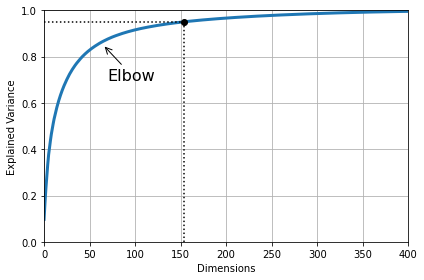

In [28]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("[8-8] explained_variance_plot")
plt.show()

In [29]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [30]:
pca.n_components_

154

### 압축을 위한 PCA

차원을 축소하고 난 후에는 훈련세트의 크기가 줄어듦. -> 알고리즘의 속도 크게 상승

예를 들어 MNIST 데이터셋에 분산의 95%를 유지하도록 PCA를 적용해봅시다.

각 샘플은 원래의 784개 특성이 아니라 150개 정도만 가지고 있을 것. 

대부분의 분산은 유지되었지만 데이터셋은 원본크기의 20%미만이 됨.

|

또한 압축된 데이터셋에 PCA 투영의 변환을 반대로 적용해 784개의 차원으로 되돌릴수도 있음.

투영에서 일정량의 정보(유실된 5%의 분산)를 잃어버렸기 때문에 이렇게 해도 원본은 얻을 수 없음.

하지만 원본과 매우 비슷할 것. 

원본데이터와 재구성된 데이터 사이의 평균 제곱 거리를 재구성 오차라고 한다.

In [31]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [32]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

그림 저장 [8-9] mnist_compression_plot


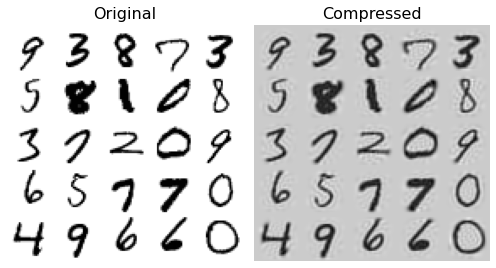

In [33]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("[8-9] mnist_compression_plot")

In [34]:
X_reduced_pca = X_reduced

**Equation 8-3: PCA inverse transformation, back to the original number of dimensions**

$
\mathbf{X}_{\text{recovered}} = \mathbf{X}_{d\text{-proj}} {\mathbf{W}_d}^T
$

### 랜덤 PCA

svd_solver="randomized"으로 지정하면 사이킷런은 랜덤 PCA라 부르는 확률적 알고리즘을 사용해

처음 $d$ 개의 주성분에 대한 근삿값을 빠르게 찾음.

계산 복잡도는 $O(m \times d^2)+O(d^3)$ (완전한 SVD 방식은 $O(m \times n^2)+O(n^3)$, 

d가 n보다 작으면 완전 SVD보다 빠르다.)

In [35]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

### 점진적 PCA

PCA 구현의 문제는 SVD 알고리즘을 실행하기 위해 전체 훈련 세트를 메모리에 올려야 한다는 것

점진적 PCA(IPCA): 훈련 세트를 미니배치로 나눈 뒤 IPCA 알고리즘에 한 번에 하나씩 주입

(훈련 세트가 클 때 유용, 온라인 PCA 적용 가능)

|

다음코드는 MNIST 데이터셋을 100개의 미니배치로 나누고 사이킷런의 IncrementalPCA 에 주입하여

MNIST 데이터셋의 차원을 154개로 줄임. 전체훈련세트를 사용하는 fit()이 아니라 partial_fit()를

미니배치마다 호출해야 함.

In [36]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # 책에는 없음
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [37]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

압축이 잘 되었는지 확인해 보죠:

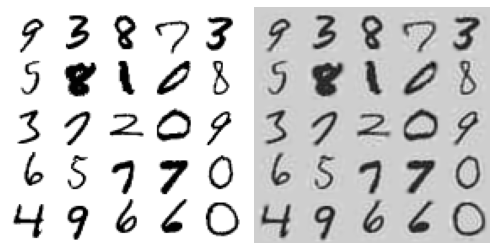

In [38]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [39]:
X_reduced_inc_pca = X_reduced

일반 PCA와 점진적 PCA로 MNIST 데이터를 변환한 결과를 비교해 보겠습니다. 먼저 평균이 같은지 확인합니다: 

In [40]:
np.allclose(pca.mean_, inc_pca.mean_)

True

하지만 결과는 완전히 동일하지 않습니다. 점진적 PCA는 아주 훌륭한 근사치를 제공하지만 완벽하지는 않습니다:

In [41]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

**`memmap()` 사용하기**

`memmap()` 구조를 만들고 MNIST 데이터를 복사합니다. 이는 일반적으로 별도의 프로그램에서 먼저 수행됩니다:

In [42]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

이제 데이터가 디스크에 저장되었는지 확인하기 위해 `memmap()` 객체를 삭제합니다.

In [43]:
del X_mm

다음에 다른 프로그램에서 데이터를 로드하여 훈련에 사용합니다:

In [44]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, n_components=154)

## 커널 PCA (kPCA)

샘플을 매우 높은 고차원 공간(특성 공간)으로 암묵적으로 매핑하는 커널 기법을 PCA에 적용하여 

차원 축소를 위한 복잡한 비선형 투형을 수행하는 것을 커널 PCA라고 함.

해당 기법은 투영된 후에 샘플의 군집을 유지하거나 꼬인 매니폴드에 가까운 데이터셋을 펼칠 때도 유용

In [45]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [46]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [47]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

[8-10]은 (단순히 PCA를 사용한 것과 동일한) 선형 커널, RBF 커널, 시그모이드 커널을 사용해

2차원으로 축소시킨 스위스롤의 모습

**<그림 8-10. 여러 가지 커널의 kPCA를 사용해 2D로 축소시킨 스위스 롤> 생성 코드**

그림 저장 [8-10] kernel_pca_plot


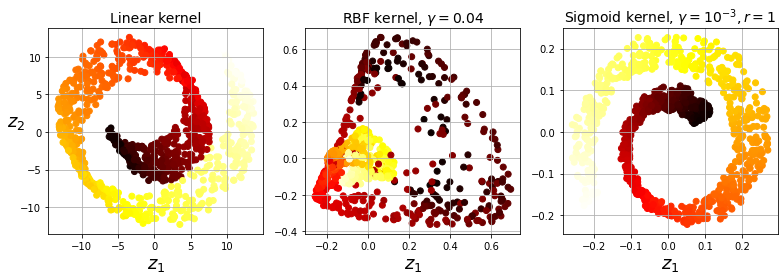

In [48]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components=2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("[8-10] kernel_pca_plot")
plt.show()

### 커널 선택과 하이퍼파라미터 튜닝

kPCA는 비지도 학습이기 때문에 좋은 커널과 하이퍼파라미터를 선택하기 위한 명확한 기준이 없음.

하지만 차원축소는 종종 지도 학습의 전처리 단계로 활용되므로 그리드탐색을 사용할 수 있음.

그리드 탐색을 사용하여 주어진 문제에서 성능이 가장 좋은 커널과 하이퍼파라미터를 선택

다음 코드는 2단계의 파이프라인을 만드는데, 먼저 kPCA를 사용해 차원을 2차원으로 축소하고

분류를 위해 로지스틱회귀를 사용. 그런 다음 파이프라인 마지막 단계에서 가장 높은 분류 정확도를 위해

GridSearchCV를 사용해 kPCA의 가장 좋은 커널과 gamma 파라미터를 찾음.

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

가장 좋은 커널과 하이퍼파라미터 확인

In [50]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


완전한 비지도 학습 방법으로, 가장 낮은 재구성 오차를 만드는 커널과 하이퍼파라미터를 선택하는 방식도 있다.

(but 선형 PCA만큼 재구성은 쉽지 않다.)

[8-11]은 스위스롤의 원본 3D 데이터셋과 RBF커널의 kPCA를 적용한 2D 데이터셋을 보여줌.

커널트릭 덕분에 이 변환은 특성 맵 $\phi$ 를 사용해 훈련세트를 무한차원의 특성공간에 매핑한 다음,

변환된 데이터셋을 선형 PCA를 사용해 2D로 투영한 것과 수학적으로 동일.

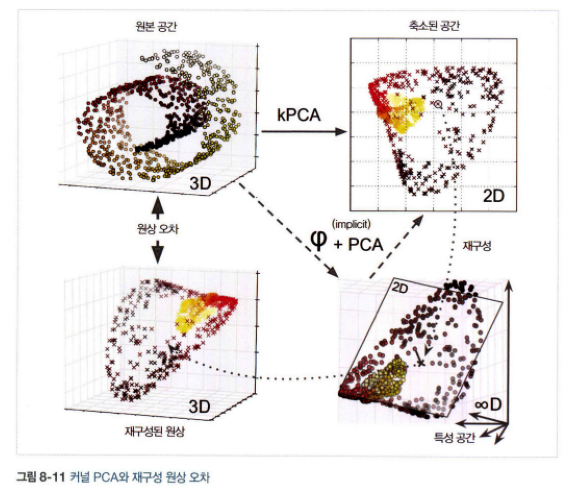

In [51]:
filename = "dim_red10.png"
images_path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
show_img = mpimg.imread(os.path.join(images_path, filename))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(show_img)

* 위 그림은 원본 3D 데이터셋(왼쪽 위)과 RBF 커널의 kPCA를 적용한 2D 데이터셋(오른쪽 위), 

  커널 트릭 덕분에 특성 맵 $\phi$ 를 사용하여 훈련 세트를 무한 차원의 특성 공간으로 매핑, 

  변환된 데이터셋을 선형 PCA를 사용해 2D로 투영(오른쪽 아래)

* 축소된 공간에 잇는 샘플에 대해 선형 PCA를 역전시키면 재구성된 데이터 포인트는 

  원본 공간이 아닌 특성 공간에 놓인다(왼쪽 아래)

* 특성 공간은 무한 차원이기 때문에 재구성된 포인트를 계산할 수 없고 

  재구성에 따른 실제 에러를 계산할 수 없다.
  
* but 재구성된 포인트에 가깝게 매핑된 원본 공간의 포인트를 찾을 수 있다. 이를 재구성 원상이라고 한다.
  
  재구성 원상을 이용하여 원본 샘플과의 오차를 최소하하는 커널과 하이퍼파라미터 선택 가능

재구성하는 한 가지 방법은 투영된 샘플을 훈련세트로, 원본샘플을 타깃으로 하는 지도 학습 회귀 모델을

훈련 시키는 것. 사이킷런에서는 다음코드와 같이 fit_inverse_transform=True로 지정하면 이를 자동으로 수행

In [52]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

#### NOTE_

KernelPCA는 fit_inverse_transform=False가 기본값이며 inverse_transform()를 가지고 있지 않음.

이 메서드는 fit_inverse_transform=True를 지정했을 때만 생성됨.

재구성 원상 오차를 계산가능

In [53]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576611

이렇게 되면 재구성 원상 오차를 최소화하는 커널과 하이퍼파라미터를 찾기위한 교차검증으로

그리드 탐색을 사용할 수 있음.

## 지역 선형 임베딩(LLE)

지역선형 임베딩은 또 다른 강력한 비선형 차원 축소(NLDR) 기술.

이전 알고리즘처럼 투영에 의존하지 않는 매니폴드 학습. 간단히 말해 LLE는

먼저 각 훈련샘플이 가장 가까운 이웃(c.n.)에 얼마나 선형적으로 연관되어 있는지 측정.

그 다음 국부적인 관계가 가장 잘 보존되는 훈련세트의 저차원 표현을 찾음.

잡음이 너무 많지 않은 경우 꼬인 매니폴드를 펼치는 데 잘 작동함.

In [54]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

사이킷런의 LocallyLinearEmbedding을 사용해 스위스롤을 펼침.

In [55]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

결과 2D 데이터셋이 [8-12]에 나타나 있음. 그림에서 볼 수 있듯이 스위스 롤이 완전히 펼쳐졌고

지역적으로는 샘플 간 거리가 잘 보존되어 있음. 그러나 크게 보면 샘플 간 거리가 잘 유지되어 있지 않음.

펼쳐진 스위스롤의 오른쪽은 압축되어 있고 왼쪽은 확장되어 있음.

그럼에도 LLE는 매니폴드를 모델링하는데 잘 작동.

그림 저장 [8-12] lle_unrolling_plot


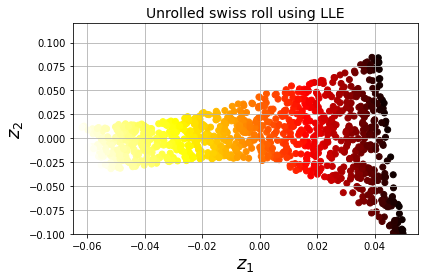

In [56]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("[8-12] lle_unrolling_plot")
plt.show()

- 지역 선형 임베딩 방법의 작동하는 방식은 다음과 같음.

각 훈련 샘플 $x^{(i)}$ 에 대해 가장 가까운 k개의 샘플을 찾는다.

이 이웃에 대한 선형 함수로 $x^{(i)}$ 를 재구성한다. ($x^{(i)}$ 와 $\sum\limits_{j=1}^{m}{w_{i,j}}\mathbf{x}^{(i)}$ 사이의 

제곱 거리가 최소가 되는 $w_{i,j}$ 를 찾는 것, $W$ 는 가중치 $w_{i,j}$ 를 모두 담은 가중치 행렬)

선형적인 지역 관계 모델링

|

**Equation 8-4: LLE step 1: linearly modeling local relationships**


$
\begin{split}
& \hat{\mathbf{W}} = \underset{\mathbf{W}}{\operatorname{argmin}}{\displaystyle \sum\limits_{i=1}^{m}} \left\|\mathbf{x}^{(i)} - \sum\limits_{j=1}^{m}{w_{i,j}}\mathbf{x}^{(j)}\right\|^2\\
& \text{subject to }
\begin{cases}
  w_{i,j}=0 & \text{if }\mathbf{x}^{(j)} \text{ is not one of the }k\text{ c.n. of }\mathbf{x}^{(i)}\\
  \sum\limits_{j=1}^{m}w_{i,j} = 1 & \text{for }i=1, 2, \dots, m
\end{cases}
\end{split}
$

|

가능한 이 관계가 보존되도록 훈련 샘플을 d차원 동간 ($d<n$)으로 매핑, 만약 $z^{(i)}$ 가 d차원 공간에서

$x^{(i)}$ 의 상이라면 가능한 $z^{(i)}$ 와 $\sum\limits_{j=1}^{m}{\hat{w}_{i,j}}\mathbf{z}^{(j)}$ 사이의 거리가 최소화 되어야 한다. 

($Z$ 는 모든 $z^{(i)}$ 를 포함하는 행렬)

선형적인 지역 관계 모델링은 샘플을 고정하고 최적의 가중치를 찾는 대신, 차원 축소는 반대로 가중치를 고정하고 저차원의 공간에서 샘플 이미지의 최적 위치를 찾는다.

관계를 보존하는 차원 축소

**Equation 8-5: LLE step 2: reducing dimensionality while preserving relationships**

$\hat{\mathbf{Z}} = \underset{\mathbf{Z}}{\operatorname{argmin}}{\displaystyle \sum\limits_{i=1}^{m}} \left\|\mathbf{z}^{(i)} - \sum\limits_{j=1}^{m}{\hat{w}_{i,j}}\mathbf{z}^{(j)}\right\|^2
$

* 잡음이 너무 많지 않은 경우 꼬인 매니폴드를 펼치는 데 잘 작동

* 계산 복잡도는 k개의 가까운 이웃을 찾는데 $O(m\log(m)n\log(k))$, 

  가중치 최적화에 $O(mnk^3)$, 저차원표현을 만드는데 $O(dm^2)$

* 대량의 데이터셋에 적용하기 어렵다(계산 복잡도에서 저차원 표현 만들때 $m^2$ 때문)

## 다른 차원 축소 기법

* 랜덤 투영: 랜덤한 선형 투영을 사용해 데이터를 저차원 공간으로 투영.

* 다차원 스케일링(MDS): 샘플 간의 거리를 보존하면서 차원을 축소

* Isomap: 각 샘플을 가장 가까운 이웃과 연결하는 식으로 그래프 생성, 

  그 다음 샘플 간의 지오데식 거리(두 노드 사이의 최단 경로를 이루는 노드의 수)를 유지하면서 차원 축소

* t-SNE: 비슷한 샘플은 가까이, 비슷하지 않은 샘플은 멀리 떨어지도록 하면서 차원 축소. 

  주로 시각화에 사용(고차원 공간에 있는 샘플의 군집을 시각화할 때)

* 선형 판별 분석(LDA): 원래는 분류 알고리즘이나 훈련 과정에서 클래스 사이를 잘 구분하는 축을 학습. 

  이 축을 데이터가 투영되는 초평면을 정의하는 데 사용. 투영을 통해 가능한 클래스를 멀리 떨어지게 
  
  유지시키므로 SVM 분류기 같은 다른 분류 알고리즘을 적용하기 전에 차원 축소시키는 데 좋다.

In [57]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [58]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [59]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [60]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

그림 저장 other_dim_reduction_plot


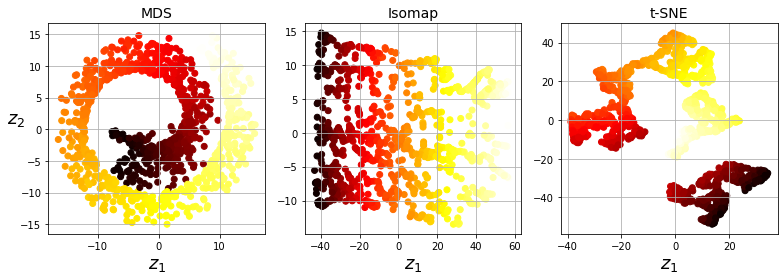

In [61]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()